In [74]:
import random
import numpy as np
import copy 
import queue
import matplotlib.pyplot as plt

class Building:
    counter = 0
    def __init__(self, num_resources=3, max_build_count=(1, 15), building_size_bounds=(1, 50), infinite_prob=0.0, infinite_buildings=False, struct_value_bounds=(1, 5)):
        self.name = f"{Building.counter}"
        Building.counter += 1
        self.resource_values = np.random.randint(*struct_value_bounds, size=num_resources)
        if infinite_buildings or np.random.rand() < infinite_prob:
            self.max_build_count = np.inf
        else:
            self.max_build_count = np.random.randint(*max_build_count)
        self.building_size = np.random.randint(*building_size_bounds)
        self.built_locations = []
        self.build_rem = self.max_build_count

    def display(self):
        print()
        print(f"Name: {self.name}")
        print(f"Building Resource Values: {self.resource_values}")
        print(f"Max Build Count: {self.max_build_count}")
        print(f"Building Size: {self.building_size}")
        print(f"Built Locations: {self.built_locations}")
        print(f"Building_Remaining: {self.build_rem}")
        print()
    

class Land:
    counter = 0
    def __init__(self, space_range=(100, 500), num_resources=3, mean=.5, std=.2, bounds=(0,2), rounding=2):
        self.name = f"L{Land.counter}"
        Land.counter += 1
        self.space = np.random.randint(space_range[0], space_range[1] + 1)
        # Make guassian distribution between 0 and 2 centered around .5 with standard dev of .2 (if using default values)
        self.resource_values = np.round(np.clip(np.random.normal(mean, std, num_resources), bounds[0], bounds[1]), rounding)
        self.rem_space = self.space
        self.built_buildings = []
        self.building_prod = [0]*num_resources
        self.calc_prod = [0]*num_resources

    def construct_building(self, building):
        # Run a check to see if the building can be made when looking at size/build contraints
        if building.build_rem > 0 and building.building_size <= self.rem_space:
            # Update Land variables
            self.rem_space -= building.building_size
            self.built_buildings.append(building.name)

            # Update Building variables
            building.build_rem -= 1
            building.built_locations.append(self.name)

            # Update resource production
            self.building_prod += building.resource_values
            self.calc_prod = self.resource_values * self.building_prod


    def display(self):
        print()
        print(f"Name: {self.name}")
        print(f"Space: {self.space}")
        print(f"Resource Values: {self.resource_values}")
        print(f"Remaining_Space: {self.rem_space}")
        print(f"Built Buildings List: {self.built_buildings}")
        print(f"Building Production: {self.building_prod}")
        print(f"Calc Production: {self.calc_prod}")
        print()

In [63]:
############################### Problem Space Variables ################################

# Prototype params to forumlate problem space, there are the default params

# Resources Params
num_resources=3

# Building Params
max_build_count=(1, 15)
building_size_bounds=(1, 50)
infinite_prob=0.0
infinite_buildings=False
struct_value_bounds=(1, 5)

# Land Params
space_range = (100, 500)
mean=.5
std=.2
bounds=(0,2)
rounding=2

# Problem size 
# TODO, Balance this with params: max_build_count, building_size_bounds, space_range, create function f(max_build_count, building_size_bounds, space_range, sparsity_score) -> num_buildings, num_land
# Where sparsity score is a value between (0,1) which detriminates some ratio between total building space available/total land space
num_buildings = 20
num_land = 5
# If True Provide weighting scheme of resources ex [1, 0, 0] means you are only optimizing for resource 0, 
optimize_resource = False
resource_weights = [1,1,1]



In [64]:
# Use default params
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
buildings = [Building() for _ in range(num_buildings)]
lands = [Land() for _ in range(num_land)]

In [65]:
# Random Algorithm to distribute buildings randomly among lands
# Algorithm Summary: Choose a piece of Land -> Fill Land with random buildings -> When full move to next land and repeat
def random_algorithm(buildings, lands):
    lands_copy = copy.deepcopy(lands)
    buildings_copy = copy.deepcopy(buildings)
    for land in lands_copy:
        while land.rem_space > 0:
            # Filter available buildings that can fit in the remaining space
            available_buildings = [b for b in buildings_copy if b.building_size <= land.rem_space and b.build_rem > 0]
            # No available buildings that can fit
            if not available_buildings:
                break
            building = random.choice(available_buildings)
            land.construct_building(building)
    return buildings_copy, lands_copy

# Greedy Algorithm to greedyly choose best building per land
# Algorithm Summary: Create queue of best land based on resource values, then create queue based on best building/space efficiency,
# place buildings until queue empty or land is filled repeat for all land
def greedy_algorithm(buildings, lands):
    lands_copy = copy.deepcopy(lands)
    buildings_copy = copy.deepcopy(buildings)

    # Sort lands by total resource values, richest land is at the top of the queue
    lands_copy.sort(key=lambda land: sum(land.resource_values), reverse=True)

    for land in lands_copy:
        # Sort buildings by space efficiency (resource values*land resources)/building size
        buildings_copy.sort(key=lambda building: sum((land.resource_values * building.resource_values)/building.building_size), reverse=True)

        # Add most efficent building until no longer possible
        for building in buildings_copy:
            while (land.rem_space >= building.building_size) and building.build_rem >= 1:
                land.construct_building(building)

    return buildings_copy, lands_copy

def calculate_total_production(lands):
    total_production = np.zeros(num_resources)
    for land in lands:
        total_production += land.calc_prod
    return total_production

In [89]:
greedy_buildings, greedy_land = greedy_algorithm(buildings, lands)
random_buildings, random_land = random_algorithm(buildings, lands)


# Calculate and display total production score
total_production_score = calculate_total_production(random_land)
print(f"Total Production Score with Random Algorithm: {total_production_score} \nTotal Production: {sum(total_production_score)}")

total_production_score = calculate_total_production(greedy_land)
print(f"Total Production Score with Greedy Algorithm: {total_production_score} \nTotal Production: {sum(total_production_score)}")

Total Production Score with Random Algorithm: [120.19 137.8  110.32] 
Total Production: 368.31
Total Production Score with Greedy Algorithm: [194.34 205.82 150.88] 
Total Production: 551.04


In [76]:
scores = []
for i in range(1000000):
    random_buildings, random_land = random_algorithm(buildings, lands)
    total_production_score = calculate_total_production(random_land)
    scores.append(sum(total_production_score))

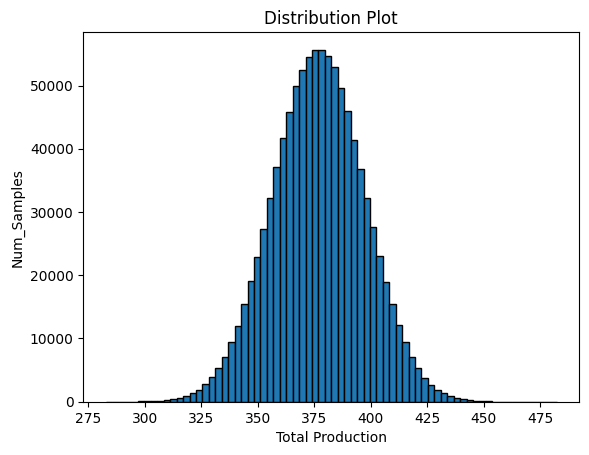

In [97]:
plt.hist(scores, bins=70, edgecolor='black')

# Set labels and title
plt.xlabel('Total Production')
plt.ylabel('Num_Samples')
plt.title('Distribution Plot')

# Show the plot
plt.show()

In [82]:
# Print out of Randomized Stats
print(f"Mean: {np.round(np.mean(scores), 2)}")
print(f"Standard Deviation: {np.round(np.std(scores), 2)}")
print(f"Median: {np.median(scores)}")
print(f"Minimum: {np.round(np.min(scores), 2)}")
print(f"Maximum: {np.max(scores)}")

Mean: 376.75
Standard Deviation: 20.32
Median: 376.78
Minimum: 282.69
Maximum: 482.31
